In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (13,10)
plt.style.use('bmh')
from datetime import timedelta
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
import seaborn as sns
from sklearn.metrics import *
from keras.callbacks import *
# from google.colab import drive 
# drive.mount('/content/drive')

In [2]:
def preprocess(file):
    data = pd.read_csv(file)
    HUElec = pd.melt(data, id_vars=["Date"], var_name='time')
    HUElec['time'] = pd.to_timedelta(HUElec['time'].apply(lambda t: f"{t[:5]}:00")) - timedelta(minutes=30)
    HUElec['Date'] = pd.to_datetime(HUElec['Date'], format="%m/%d/%Y")
    HUElec['Datetime'] = HUElec['Date'] + HUElec['time']
    HUElec = HUElec.set_index('Datetime')
    HUElec = HUElec.drop(['Date', 'time'], axis=1).sort_index()

    return HUElec

In [5]:
file = 'GTWYElec.csv'
data = preprocess(file)

df = data.resample(rule='D').sum()
df = df[:-1]

df.tail(12)

,value
Datetime,
2022-02-16,2603.84
2022-02-17,2630.88
2022-02-18,2553.92
2022-02-19,1564.88
2022-02-20,1498.64
2022-02-21,2706.88
2022-02-22,2726.24
2022-02-23,2608.80
2022-02-24,2747.04


In [6]:
len(df)

5045

In [7]:
df.index[:5]

DatetimeIndex(['2008-05-07', '2008-05-08', '2008-05-09', '2008-05-10',
               '2008-05-11'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

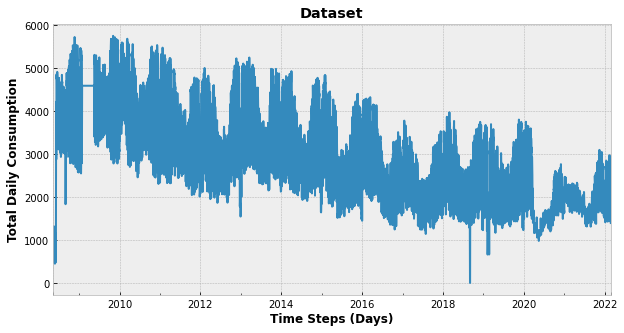

In [8]:
# Since data preprocessing has come to an end, the plot is presented
df['value'].plot(figsize=(10,5))
plt.ylabel('Total Daily Consumption',fontweight='bold')
plt.xlabel('Time Steps (Days)',fontweight='bold')
plt.title('Dataset',fontweight='bold');

In [9]:
df.shape

(5045, 1)

# Part B
## Case Study I
**a) LSTM predictions - Comparison of actual (test_data) with predicted values**

In [10]:
# Test size: 36
test_size = 365
test_index = len(df) - test_size

In [11]:
# Dataset is split into training and test data
train = df.iloc[:test_index]
test = df.iloc[test_index:]

In [12]:
train.head()

,value
Datetime,
2008-05-07,690.060
2008-05-08,1275.922
2008-05-09,1223.394
2008-05-10,541.128
2008-05-11,555.986


In [13]:
test.head()

,value
Datetime,
2021-02-28,1767.520
2021-03-01,2218.040
2021-03-02,2272.202
2021-03-03,2267.480
2021-03-04,2222.920


In [14]:
# Scaling the training and test data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [15]:
# Importing the keras library and the TimeseriesGenerator
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# Length can be considered as the number of entries that are to be used as inputs
# in order to determine/predict the next number in a sequence. 

# Number of features value is 1 as only one dataset feature is examined. The Date is not a feature as it comprises the index
# of the dataset (in Monthly Time steps)

# batch_size of value 1 has been selected, where at each batch 11 time series values are to be trained so as
# to predict the next number in the sequence
length = 30
n_features=1
time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [17]:
# First batch of the time_series_generator- train and test values
X,y=time_series_generator[0]

In [18]:
# At the first batch, the generator takes the first 14 values and trains them to predict the next number
X

array([[[0.1200258 ],
        [0.22192789],
        [0.21279141],
        [0.09412126],
        [0.0967056 ],
        [0.19133093],
        [0.20341525],
        [0.20471072],
        [0.22990143],
        [0.21825959],
        [0.08197988],
        [0.08537162],
        [0.21026796],
        [0.18848169],
        [0.18761271],
        [0.17763682],
        [0.17749594],
        [0.08133598],
        [0.07903272],
        [0.08115891],
        [0.07892349],
        [0.18877842],
        [0.1806106 ],
        [0.20235581],
        [0.08185709],
        [0.08322613],
        [0.19837113],
        [0.1980857 ],
        [0.15103585],
        [0.59535864]]])

In [19]:
# As it can be observed, the first 11 scaled training 'MonthlyMinTemp' values are the X input values
scaled_train[:length]

array([[0.1200258 ],
       [0.22192789],
       [0.21279141],
       [0.09412126],
       [0.0967056 ],
       [0.19133093],
       [0.20341525],
       [0.20471072],
       [0.22990143],
       [0.21825959],
       [0.08197988],
       [0.08537162],
       [0.21026796],
       [0.18848169],
       [0.18761271],
       [0.17763682],
       [0.17749594],
       [0.08133598],
       [0.07903272],
       [0.08115891],
       [0.07892349],
       [0.18877842],
       [0.1806106 ],
       [0.20235581],
       [0.08185709],
       [0.08322613],
       [0.19837113],
       [0.1980857 ],
       [0.15103585],
       [0.59535864]])

In [20]:
# The y value of the time_series_generator first batch corresponds to the 12th [index 11] value of the scaled train data
print(y)
print(scaled_train[length])

[[0.73231443]]
[0.73231443]


In [21]:
# Importing the necessary libraries to create/construct the neural network model
from keras import initializers
import tensorflow as tf


# Use of the he_uniform initializer to set the initial random weights of the model layers. The bias initializer is set to a
# very small value (e.g. 0.01) to ensure that the neurons will fire at the beginning of the training process due to the use
# of a rectified linear unit as transfer (activation) function
initializer = tf.keras.initializers.he_uniform(seed=0)
# Initially, the network model is defined 
model = Sequential()

# Hidden layer neurons are chosen to be 14  which is equal to the defined length (number of past time series data per batch)
# Selected Activation function has been the rectified linear unit
model.add(LSTM(length, activation='relu', input_shape=(length, n_features),kernel_initializer=initializer,
                     bias_initializer=initializers.Constant(0.01)))
# The output layer consists of 1 neuron with a 'linear' activation fuction 
model.add(Dense(1,activation='linear',kernel_initializer=initializer,
                     bias_initializer=initializers.Constant(0.01)))

opt = tf.keras.optimizers.Adam(learning_rate=0.01,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-8)

model.compile(optimizer=opt, loss='mse')

# A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
# the use of scaled_test values for validation purposes
time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

# Demonstration of EarlyStopping. LSTM training stops if the required conditions are met
from keras.callbacks import EarlyStopping
Early_Stopping = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

# The model is ready to be trained for a maximum of 100 epochs. The training process is monitored and at each epoch both 
# training and validation losses can be observed due to the presence of the time_series_val_generator
model.fit_generator(time_series_generator,epochs=100,
                    validation_data=time_series_val_generator ,
                   callbacks=[Early_Stopping])

Epoch 1/100


<ipython-input-21-a050fa274058>:38: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(time_series_generator,epochs=100,


4650/4650 [==============================] - 29s 6ms/step - loss: 0.0146 - val_loss: 0.0017
Epoch 2/100
4650/4650 [==============================] - 27s 6ms/step - loss: 0.0070 - val_loss: 9.6965e-04
Epoch 3/100
4650/4650 [==============================] - 27s 6ms/step - loss: 0.0057 - val_loss: 0.0011
Epoch 4/100
4650/4650 [==============================] - 27s 6ms/step - loss: 0.0048 - val_loss: 0.0010
Epoch 5/100
4650/4650 [==============================] - 27s 6ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 6/100
4650/4650 [==============================] - 27s 6ms/step - loss: 0.0037 - val_loss: 7.9026e-04
Epoch 7/100
 414/4650 [=>............................] - ETA: 25s - loss: 0.0052

KeyboardInterrupt: 

Text(0, 0.5, "Loss-'MSE'")

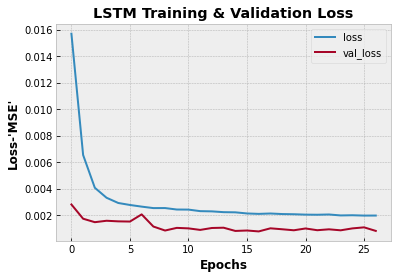

In [20]:
# Training and validation loss plots
loss = pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training & Validation Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold')

In [21]:
# Determining all LSTM Training values so as to compare them with the actual
# dataset values used for the training process
training_outputs = []
batch = scaled_train[:length].reshape((1, length, n_features))

for i in range(len(scaled_train[length:])):
    train_out = model.predict(batch)[0]
    training_outputs.append(train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_train[length:][i]]],axis=1)

In [22]:
# Creating a numpy array and applying the inverse_transform function to get the 4369 actual training values. 
# 156 total training points - 11 the first batch sequence = 4369
actual_train=scaled_train[length:]
actual_train=scaler.inverse_transform(actual_train)

In [23]:
# Applying the inverse_transform function to the training_outputs to get their mean MonthlyMinTemp values
train_predictions=scaler.inverse_transform(training_outputs)

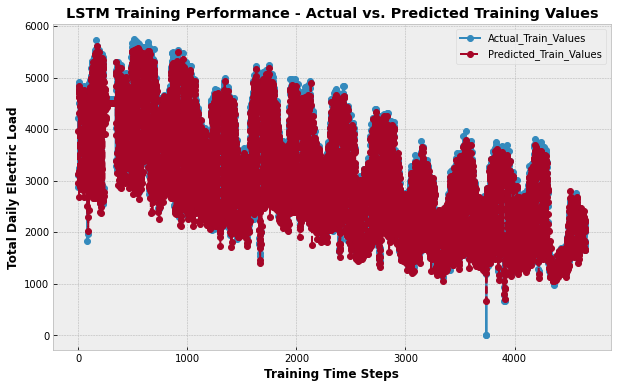

In [24]:
#'LSTM Training Performance - Actual vs. Predicted Training Values'
plt.figure(figsize=(10,6))
plt.plot(actual_train,marker='o',linestyle='-')

plt.plot(train_predictions,marker='o',linestyle='dashed')
plt.title('LSTM Training Performance - Actual vs. Predicted Training Values',fontweight='bold')
plt.legend(('Actual_Train_Values','Predicted_Train_Values'))
plt.xlabel('Training Time Steps',fontweight='bold')
plt.ylabel('Total Daily Electric Load',fontweight='bold');

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


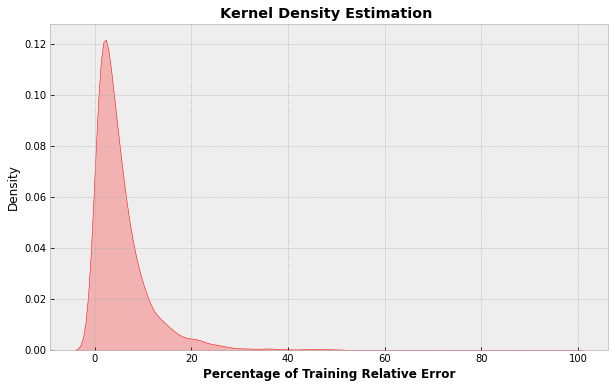

In [25]:
# Training relative Error Percentage distribution plot
train_err=abs((actual_train-train_predictions)/actual_train)*100
train_err=pd.DataFrame(train_err,columns=['Training Error'])
plt.figure(figsize=(10,6))
sns.kdeplot(train_err['Training Error'],shade=True,color='r',kernel='gau',)
plt.xlabel('Percentage of Training Relative Error',fontweight='bold')
plt.title('Kernel Density Estimation ',fontweight='bold');

In [26]:
# Summary statistics of training relative error

train_err.describe()

,Training Error
count,4651.000000
mean,inf
std,NaN
min,0.000658
25%,1.752966
50%,3.734092
75%,7.051680
max,inf


In [27]:
# Determining all LSTM predicted values so as to compare them with the actual test values 
test_outputs = []
batch = scaled_train[-length:].reshape((1, length, n_features))

for i in range(len(test)):
    test_out = model.predict(batch)[0]
    test_outputs.append(test_out) 
    batch = np.append(batch[:,1:,:],[[test_out]],axis=1)

In [28]:
# Applying the inverse_transform function to the test_outputs to get their real values
lstm_predictions = scaler.inverse_transform(test_outputs)

In [29]:
# A new test feature is created to comprise the LSTM test predictions
test['LSTM Predictions'] = lstm_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
# test(Actual) and LSTM Predictions
test

,value,LSTM Predictions
Datetime,,
2021-03-01,2218.040,2344.557164
2021-03-02,2272.202,2237.437935
2021-03-03,2267.480,2307.249626
2021-03-04,2222.920,2343.154220
2021-03-05,2207.840,2250.656583
...,...,...
2022-02-24,2747.040,1860.583449
2022-02-25,2469.200,1792.276822
2022-02-26,1410.440,1139.538920


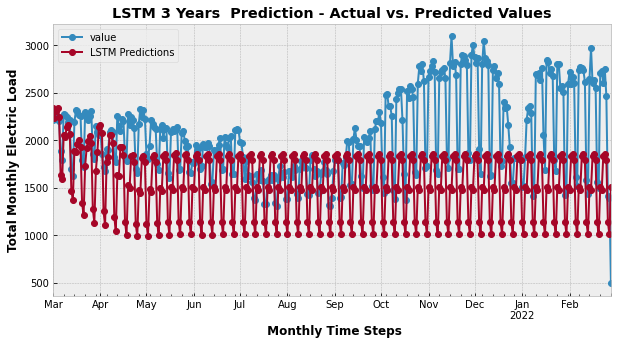

In [31]:
# Plot of the Test vs. Predicted results for a prediction horizon of 12 months (1990-01 to 1990-12)
test.plot(figsize=(10,5),marker='o',linestyle='-');
plt.title('LSTM 3 Years  Prediction - Actual vs. Predicted Values',fontweight='bold')
plt.ylabel('Total Monthly Electric Load',fontweight='bold')
plt.xlabel(' Monthly Time Steps',fontweight='bold');

In [32]:
df.iloc[length]

value    4210.269
Name: 2008-06-06 00:00:00, dtype: float64

In [42]:
# LSTM training outputs index
train_index=pd.date_range(start='2008-03',periods=4651,freq='D')

In [43]:
# Converting the train_predictions from np.ndarray to pandas dataframe
train_df=pd.DataFrame(data=train_predictions,index=train_index,columns=['Predicted_Train'])

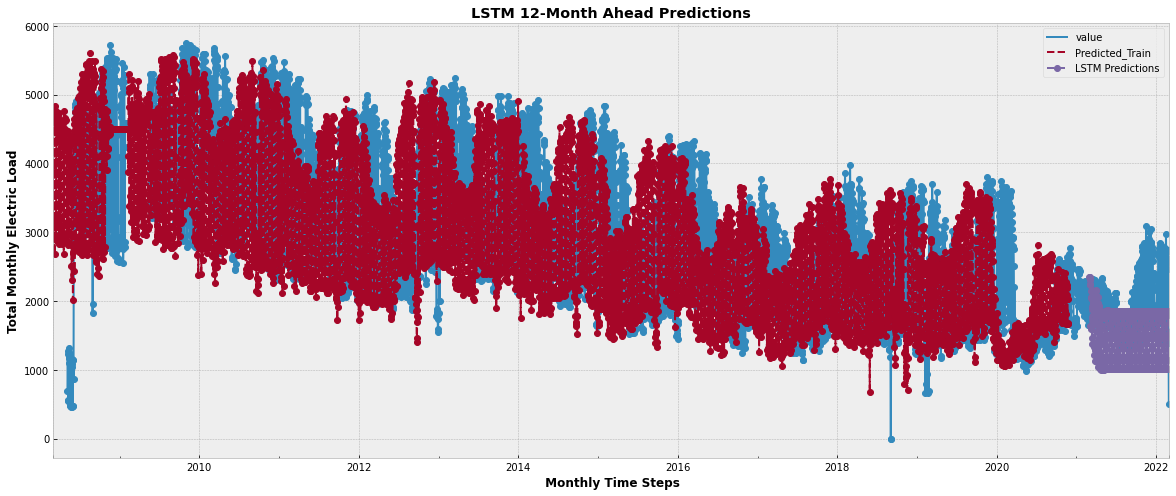

In [44]:
# Plot comprising all actual total value data, the LSTM model's training outputs and the LSTM test predictions
# The first 11 points are the initial time series samples of the first batch at the beginning of the training process.

ax=df.plot(figsize=(20,8),marker='o',linestyle='-')

train_df.plot(ax=ax,marker='o',linestyle='--')
test['LSTM Predictions'].plot(ax=ax,legend=True,marker='o',linestyle='dashed')
plt.title('LSTM 12-Month Ahead Predictions',fontweight='bold')
plt.ylabel('Total Monthly Electric Load',fontweight='bold')
plt.xlabel(' Monthly Time Steps',fontweight='bold');

In [45]:
# Root Mean Squared Error
print(np.sqrt(mean_squared_error(test['value'],test['LSTM Predictions'])))

631.7434993299044


# Case Study I
## b) LSTM forecast into the future


In [39]:
# The last 'MonthlyMinTemp' value of the dataset has date index value equal to 1990-12
df.tail(3)

,value
Datetime,
2022-02-26,1410.44
2022-02-27,1393.84
2022-02-28,496.56


In [40]:
# Initialise a new scaler
data_scaler = MinMaxScaler()
scaled_set = data_scaler.fit_transform(df)

In [46]:
# A new TimeseriesGenerator is created to include the new scaled values, with batch_size = 1 of length=12
length=30
data_generator=TimeseriesGenerator(scaled_set,scaled_set,length=length,batch_size=1)

In [ ]:
# The LSTM model is being constructed and compiled for the training process to take place
# Since the model forecasts into the future, in this case there are no validation data and no use of 
# keras callbacks ('EarlyStopping')

initializer = tf.keras.initializers.he_uniform(seed=0)
model=Sequential()
model.add(LSTM(30,activation='relu',input_shape=(length,n_features),kernel_initializer=initializer,
                     bias_initializer=initializers.Constant(0.01)))
model.add(Dense(1,activation='linear',kernel_initializer=initializer,
                     bias_initializer=initializers.Constant(0.01)))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(data_generator,epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


5016/5016 [==============================] - 65s 13ms/step - loss: 0.0160
Epoch 2/100
5016/5016 [==============================] - 57s 11ms/step - loss: 0.0079
Epoch 3/100
1294/5016 [======>.......................] - ETA: 41s - loss: 0.0069

In [ ]:
# Training Performance
loss=pd.DataFrame(model.history.history)
loss.plot()
plt.title('LSTM Training Loss',fontweight='bold')
plt.xlabel('Epochs',fontweight='bold')
plt.ylabel("Loss-'MSE'",fontweight='bold');

In [ ]:
# Determining all LSTM Training values so as to compare them with the actual  dataset input values used for the training process
full_training_outputs = []
batch = scaled_set[:length].reshape((1, length, n_features))

for i in range(len(scaled_set[length:])):
    full_train_out = model.predict(batch)[0]
    full_training_outputs.append(full_train_out) 
    batch = np.append(batch[:,1:,:],[[scaled_set[length:][i]]],axis=1)

In [ ]:
# Creating a numpy array and applying the inverse_transform function to get the 108 actual training values. 
# 168 total training points - 12 the first batch sequence = 156
f_train=scaled_set[length:]
f_train=scaler.inverse_transform(f_train)

In [ ]:
# Applying the inverse_transform function to the training_outputs to get their mean MonthlyMinTemp values
f_train_predictions=scaler.inverse_transform(full_training_outputs)

In [ ]:
#'LSTM Training Performance - Actual vs. Predicted Training Values'
plt.figure(figsize=(15,6))
plt.plot(f_train,marker='o',linestyle='-')

plt.plot(f_train_predictions,marker='o',linestyle='dashed')
plt.title('LSTM Training Performance - Actual vs. Predicted Training Values',fontweight='bold')
plt.legend(('Actual_Train_Values','Predicted_Train_Values'))
plt.xlabel('Training Time Steps',fontweight='bold')
plt.ylabel('Total Monthly Electric Load',fontweight='bold');

In [ ]:
# Training Relative Error Percentage distribution plot
f_train_err=abs((f_train-f_train_predictions)/f_train)*100
f_train_err=pd.DataFrame(f_train_err,columns=['Training Error'])
plt.figure(figsize=(10,6))
sns.kdeplot(f_train_err['Training Error'],shade=True,color='r',kernel='gau',)
plt.xlabel('Percentage of Training Relative Error',fontweight='bold')
plt.title('Kernel Density Estimation ',fontweight='bold');

In [ ]:
# Summary statistics of training_error. In this case the increase in the number of training points has led to a smaller 
# relative  percentage error mean value. Moreover, the fact that no callbacks have been set resulted in  LSTM training 
# for 100 epochs (38 epochs in the Case Study Ia), where the use of 'callbacks' has been demonstrated) and that led to 
# a more effective training of the deep learning model. 
f_train_err.describe()

In [ ]:
# LSTM training outputs index
f_train_index=pd.date_range(start='2008-03',periods=4651,freq='D')

In [ ]:
# Converting the train_predictions from np.ndarray to pandas dataframe
f_train_df=pd.DataFrame(data=f_train_predictions,index=f_train_index,columns=['Predicted_Train'])

In [ ]:
# Determining all LSTM forecasted values 
lstm_outputs=[]
batch = scaled_set[-length:].reshape((1, length, n_features))

for i in range(length):
    lstm_out = model.predict(batch)[0]
    lstm_outputs.append(lstm_out) 
    batch = np.append(batch[:,1:,:],[[lstm_out]],axis=1)

In [ ]:
# Applying the inverse_transform function to get the mean 'MonthlyMinTemp' representations 
lstm_outputs=data_scaler.inverse_transform(lstm_outputs)
lstm_outputs

In [ ]:
# Index of forecasted mean 'MontlyMinTemp' values
lstm_forecast_index=pd.date_range(start='2022-01',periods=12,freq='MS')

In [ ]:
# Converting the lstm_outputs from np.ndarray to pandas dataframe
lstm_forecast_df=pd.DataFrame(data=lstm_outputs,index=lstm_forecast_index,columns=['LSTM Forecasts'])
lstm_forecast_df

In [ ]:
# Plot comprising all actual total 'value' data,and the 12-month LSTM forecasted values.

ax=df.plot(figsize=(20,8),marker='o',linestyle='-')
lstm_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('LSTM 12-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Total Monthly Electric Load',fontweight='bold')
plt.xlabel(' Monthly Time Steps',fontweight='bold')

In [ ]:
# Plot comprising all actual MonthlyMinTemp data, the LSTM model's training outputs,and the LSTM forecasts.
# The first 12 points are the initial time series samples of the first batch at the beginning of the training process.
ax=df.plot(figsize=(15,8),marker='o',linestyle='-')
f_train_df.plot(ax=ax,marker='o',linestyle='dashed')
lstm_forecast_df.plot(ax=ax,marker='o',linestyle='--')
plt.title('LSTM 12-Month Ahead Forecast',fontweight='bold')
plt.ylabel('Total Monthly Load',fontweight='bold')
plt.xlabel(' Monthly Time Steps',fontweight='bold')